# Inference and Analysis of Gene Expression Rhythmicity using GeneRhythm
This tutorial provides a step-by-step guide on performing inference, analysis, and visualization of gene expression rhythmicity in a single dataset using GeneRhythm. We demonstrate the diverse capabilities of GeneRhythm by applying it to scRNA-seq data obtained from mouse tissue samples.

GeneRhythm leverages user-provided gene expression data by integrating wavelet transformation with deep generative modeling. This approach enables the extraction of frequency-domain features that complement traditional time-domain analyses, allowing for a more comprehensive understanding of gene expression dynamics. 

In [1]:
import subprocess
from Build_graph import *
from Frequency_extract import *
from GCN_VAE import *
from Show_result import *

# Part 1: Data loading, time and frequency information acquisition
## Obtain time information with monocle3
GeneRhythm firstly utilized monocle3 to obtain the trajectory information of single-cell RNA-seq data. trajectory_inference.R is the script to run monocle3. dataset indicated the name of dataset. mtx, barcode and gene indicate the position of the single-cell RNA-seq data.Based on the trajectory information, GeneRhythm can derive time information (Gene expression chagnes on the trajectory pesodu-time path).

In [2]:
dataset = 'mouse_embryo_blood'
mtx = './dataset/mouse_embryo_blood/counts_5k_final.mtx'
barcode = './dataset/mouse_embryo_blood/cell_meta_5kgenes_final.csv'
gene  = './dataset/mouse_embryo_blood/gene_meta_5kgenes_final.csv'
subprocess.run(["Rscript", "trajectory_inference.R", dataset, mtx， barcode, gene])

##  Frequency information generation
In this step, we harness the power of wavelet transformation to extract detailed frequency information from the gene expression data. By leveraging the trajectory information obtained from Monocle3—which orders cells along a pseudotime axis—we can capture both the temporal progression and the underlying periodic patterns of gene expression.

Wavelet transformation decomposes the gene expression profiles into various frequency components, enabling us to detect subtle oscillations and rhythmic behaviors that are often not apparent in the time domain alone. This multi-scale analysis helps reveal hidden periodicities and enriches our understanding of gene regulatory mechanisms.

By integrating the frequency-domain features with the temporal trajectory and expression, we achieve a more nuanced analysis. The frequency information complements the time-domain data, enhancing gene clustering. Ultimately, this combined approach provides a comprehensive view of the dynamic changes in gene expression, paving the way for deeper insights into cellular functions and regulatory processes.

In [3]:
trajectory_info = pd.read_csv("mouse_embryo_blood.csv")
mtx = sc.read_mtx(mtx)
mtx = mtx.X.T
barcode = pd.read_csv(barcode,sep=',',index_col=0)
gene  = pd.read_csv(gene,header=0,index_col = 0)
adata = anndata.AnnData(mtx,barcode,gene)
frequency_extract(trajectory_info, adata, dataset)

# Part 2: Model preparation and training
## GCN graph preparation
In this phase, we utilize the Mippie PPI database to extract gene-gene interaction information, thereby constructing the graph structure for our Graph Convolutional Network (GCN). Specifically, the database provides gene interaction data that has been validated by both experimental evidence and computational predictions. We treat these interactions as edges in the graph, with each gene represented as a node. By integrating this biologically informed network structure with the previously obtained gene expression and frequency information, the GCN model is better equipped to capture the regulatory relationships and functional synergies between genes. This integration ultimately enhances the accuracy and interpretability of gene clustering and biomarker identification during model training.

In [4]:
gene_info = gene
for i in range(len(gene_info)):
    gene_info.loc[i,"gene_id"] = gene_info.loc[i,"gene_id"][:18]
print(gene_info.head())
mg = mygene.MyGeneInfo()
gene_id = mg.getgenes(gene_info.loc[:,"gene_id"], fields='_id')
ids = [gene_id[i].get('_id') for i in range(len(gene_id))]
with open("mouse_embryo_blood.txt", 'w') as output:
    for row in ids:
        output.write(str(row) + '\n')

subprocess.run(["Rscript", "mippie_nc.R", 'mouse_embryo_blood.txt', 'mippie_subset_blood.tsv'])
graph_df = pd.read_csv('mippie_subnet_blood.txt', sep='\t', header=None)
build_graph_mouse(graph_df,gene_info)

## Modle training
In this stage, the model is trained using time, frequency, and expression data, along with the previously constructed graph. This integration allows the model to learn a comprehensive latent embedding that encapsulates the intricate relationships among genes. Once the model has been trained, we apply the Leiden algorithm to the latent space to identify gene clusters. These clusters represent groups of genes with similar expression dynamics and regulatory patterns, providing a valuable basis for further biological insights and downstream analysis.

In [5]:
GeneRhythm_Model(input_data = 'mouse_embryo_blood.npy',graph='graph_index.npy',sc_data = adata)

____________________________
Start Training VAE...
torch.Size([5000, 250])
Epochs: 1, AvgLoss: 36.0972
torch.Size([5000, 250])
Epochs: 2, AvgLoss: 36.0126
torch.Size([5000, 250])
Epochs: 3, AvgLoss: 35.9325
torch.Size([5000, 250])
Epochs: 4, AvgLoss: 35.8498
torch.Size([5000, 250])
Epochs: 5, AvgLoss: 35.7680
torch.Size([5000, 250])
Epochs: 6, AvgLoss: 35.6849
torch.Size([5000, 250])
Epochs: 7, AvgLoss: 35.6036
torch.Size([5000, 250])
Epochs: 8, AvgLoss: 35.5179
torch.Size([5000, 250])
Epochs: 9, AvgLoss: 35.4255
torch.Size([5000, 250])
Epochs: 10, AvgLoss: 35.3372
torch.Size([5000, 250])
Epochs: 11, AvgLoss: 35.2429
torch.Size([5000, 250])
Epochs: 12, AvgLoss: 35.1446
torch.Size([5000, 250])
Epochs: 13, AvgLoss: 35.0446
torch.Size([5000, 250])
Epochs: 14, AvgLoss: 34.9347
torch.Size([5000, 250])
Epochs: 15, AvgLoss: 34.8129
torch.Size([5000, 250])
Epochs: 16, AvgLoss: 34.6961
torch.Size([5000, 250])
Epochs: 17, AvgLoss: 34.5661
torch.Size([5000, 250])
Epochs: 18, AvgLoss: 34.4356
torc

# Part 3: Showing result
In this final phase, we visualize the outcomes of our analysis by displaying both the time and frequency information for each identified gene cluster. These visualizations help in interpreting the complex dynamics captured by the model and provide insights into the temporal progression and rhythmicity of gene expression within each cluster.

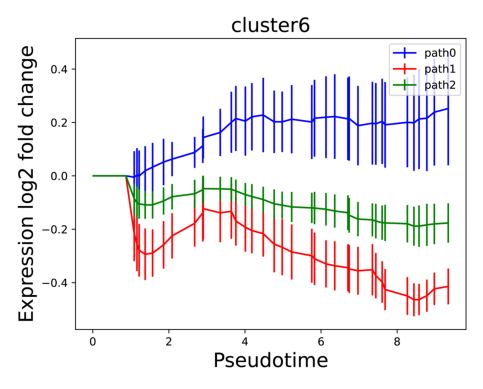

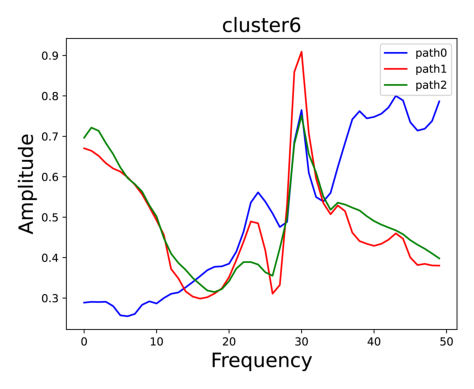

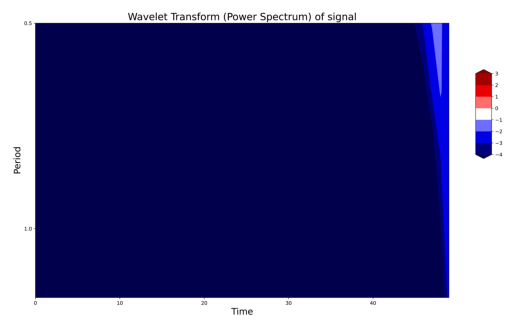

In [6]:
show_result(gene_info,trajectory_info)

Only the first eligible cluster's plots are ploted out. Other clusters's plots are saved to pdf files.

Note: As the mouse embryo blood dataset have no comparative data so the function of differential frequency genes/peaks can be found in the other datasets' tutorials. 